<a href="https://colab.research.google.com/github/hudanasrulloh/ogata-cuda/blob/main/FBT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
----

Overwriting FBT.cu


Project of Fourier-Bessel Transform

In [2]:
%%writefile FBT.cu 

// (1 Parameter ) Transform
#define _USE_MATH_DEFINES // using M_PI for pi

#include <cmath> // abs
#include <mwaitxintrin.h>
#include <iostream>
#include <fstream>
#include <functional> 
#include <cuda_runtime.h>
#include "FBT.cuh"
#include "MathFunctions.cuh" // include CUDA source file here
#include <cub/cub.cuh>
#include <cub/block/block_reduce.cuh>
#include <numeric>

#include <boost/math/tools/minima.hpp>
/*
//acknowledgement
void FBT::acknowledgement(){
    std::cout << "###############################################################################" << std::endl;
    std::cout << "#                                                                             #" << std::endl;
    std::cout << "#                Fast Bessel Transform (FBT) for TMDs                         #" << std::endl;
    std::cout << "#     Zhongbo Kang, Alexei Prokudin, Nobuo Sato, John Terry                   #" << std::endl;
    std::cout << "#                   Please cite Kang:2019ctl                                  #" << std::endl;
    std::cout << "#                  nu is Bessel function order                                #" << std::endl;
    std::cout << "#                  option = 0,1,2  (modified, unmodified, fixed h) Ogata      #" << std::endl;
    std::cout << "#                  N is number of function calls                              #" << std::endl;
    std::cout << "#                  Q initial guess where function has maximum                 #" << std::endl;
    std::cout << "#                  ::::::::::::::::::::::::::::::                             #" << std::endl;
    std::cout << "#                  :::::::::::::::::::::::::::::                              #" << std::endl;
    std::cout << "#                  Inspired by all those above guys                           #" << std::endl;
    std::cout << "#                  MODIFIED by Kasava (huda nasrulloh)                        #" << std::endl;
    std::cout << "#                  USTC, Modern Physics, 2023                                 #" << std::endl;
    std::cout << "#                  Maximum N for stability less than 500                      #" << std::endl;
    std::cout << "#                  CUDA Toolkit 8.0 or higher                                 #" << std::endl;
    std::cout << "#                  CUDA version 10.1 or higher                                #" << std::endl;
    std::cout << "#                  --- Thank you using this platform ----                     #" << std::endl;
    std::cout << "##--------- Optimized with GPU ---- By HN ----- 2023  ------------------------#" << std::endl;
    std::cout << "###############################################################################" << std::endl;
};

//citation
void FBT::citation(){
    std::cout << "###############################################################################" << std::endl;
    std::cout << "#                     Thank you for using FBT!                                #" << std::endl;
    std::cout << "# Please, cite Kang:2019ctl if used for a publication                         #" << std::endl;
    std::cout << "# --------------  on process for me Kasava (huda nasrulloh)  -------          #" << std::endl;
    std::cout << "###############################################################################" << std::endl;
};
*/
// Deconstructor
FBT::~FBT(){
  //jn_zeros0.~vector<double>();
  //citation();
};


__device__ double get_psi_device(double t){
  return ( t )*tanh( M_PI/2.* sinh( t ) );
};

__device__ double get_psip_device(double t){
  return M_PI*t*( -pow(tanh( M_PI*sinh(t)/2.),2) + 1.)*cosh(t)/2. + tanh(M_PI*sinh(t)/2.);
};

__device__ double f_for_ogata_device(double x, double q){
  return g_(x/q)/q;
};


// Constructor
FBT::FBT(double _nu, int _option, int _N, double _Q){
    if( _nu >= 0.){
    this->nu     = _nu;
    } else {
        std::cerr << " The value of nu = " << _nu << " is not supported." << std::endl;
        std::cerr << " Falling back to default  nu = " << FBT::nu_def << std::endl;
        this->nu     = FBT::nu_def;
    }

    if( _N >= 1){
        this->N     = _N;
    } else {
        std::cerr << " The value of N = " << _N << " is not supported." << std::endl;
        std::cerr << " Falling back to default  N = "  << FBT::N_def <<std::endl;
        this->N     = FBT::N_def;
    }

    if( _Q > 0){
        this->Q     = _Q;
    } else {
        std::cerr << " The value of Q = " << _Q << " is not supported." << std::endl;
        std::cerr << " Falling back to default  Q = "  << FBT::Q_def <<std::endl;
        this->Q     = FBT::Q_def;
    }

    if( _option <= 2 && _option >= 0){
        this->option     = _option;
    } else {
        std::cerr << " The value of option = " << _option << " is not supported." << std::endl;
        std::cerr << " Falling back to default  option = "  << FBT::option_def <<std::endl;
        this->option     = FBT::option_def;
    }

    // read precomputed data from a file
    std::string filename = "precomputed_data.txt";
    std::ifstream in_file(filename);
    std::vector<double> jn_zeros0_host, zeros_host, xi_host, Jp1_host, w_host;
    if (in_file.is_open()) {
        double a, b, c, d, e;
        while (in_file >> a >> b >> c >> d >> e) {
            jn_zeros0_host.push_back(a);
            zeros_host.push_back(b);
            xi_host.push_back(c);
            Jp1_host.push_back(d);
            w_host.push_back(e);
        }
    in_file.close();
    } else {
        std::cerr << "Unable to open file " << filename << std::endl;
    // handle error
    }
    this->jn_zeros0 = jn_zeros0_host;
    this->zeros = zeros_host;
    this-> xi = xi_host ;
    this-> w = w_host;

    //acknowledgement();
};


__global__ void ogatau_kernel(int N, double q, double* h, double* xi, double* w, double* d_block_results) {
    typedef cub::BlockReduce<double, 128> BlockReduce;
    __shared__ typename BlockReduce::TempStorage temp_storage;

    int i = threadIdx.x + blockIdx.x * blockDim.x;

    double thread_data = 0;
    if (i < N) {
        int nu = 0;
        double knots = xi[i]*(*h);
        double F = f_for_ogata_device(knots, q)*jn(nu, knots);
        thread_data = (*h)*w[i]*F;  // Calculate the result in each thread
    }

    double block_sum = BlockReduce(temp_storage).Sum(thread_data);

    // Only the first thread in the block writes to global memory
    if (threadIdx.x == 0) {
        d_block_results[blockIdx.x] = block_sum;
    }
}

__global__ void ogatat_kernel(int N, double q, double* h, double* xi, double* w, double* d_block_results) {
    typedef cub::BlockReduce<double, 128> BlockReduce;
    __shared__ typename BlockReduce::TempStorage temp_storage;

    int i = threadIdx.x + blockIdx.x * blockDim.x;

    double thread_data = 0;
    if (i < N) {
        int nu = 0;
        double knots = M_PI/(*h)*get_psi_device((*h)*xi[i]);
        double Jnu = jn(nu, knots); // Using j0() here, assuming nu = 0
        double F = f_for_ogata_device(knots, q);
        double psip = std::isnan(get_psip_device((*h)*xi[i])) ? 1. : get_psip_device((*h)*xi[i]);
        thread_data = M_PI * F * Jnu * psip * w[i];  // Calculate the result in each thread
    
    }

    double block_sum = BlockReduce(temp_storage).Sum(thread_data);

    // Only the first thread in the block writes to global memory
    if (threadIdx.x == 0) {
        d_block_results[blockIdx.x] = block_sum;
        
    }
}


//double f_for_get_hu
double f_for_get_hu(double x, std::function<double (double) > g, double q){
   return -abs(x*g(x/q));
};

//"""Determines the untransformed hu by maximizing contribution to first node."""
double FBT::get_hu(std::function<double (double) > f, double q){
  double Q = this->Q;

  double zero1 = jn_zeros0[0];
  const int double_bits = std::numeric_limits<double>::digits;
  std::pair<double, double> r = boost::math::tools::brent_find_minima(std::bind(f_for_get_hu, std::placeholders::_1, f, q), Q/10., 10.*Q, double_bits);

  double hu = r.first/zero1*M_PI;
  if(hu >= 2.){
    hu = 2.;
//    std::cerr<< "Warning: Number of nodes is too small N = " << this->N << std::endl;
  }

  return hu;
};


//"Determine transformed ht from untransformed hu."
double FBT::get_ht(double hu){
  int N = this->N;

  double zeroN = double(jn_zeros0[N-1]);

  return M_PI/zeroN*asinh(2./M_PI*atanh(hu/M_PI));
};

double FBT::fbt(double q){

    double hu = 0.0;
    double ht = 0.0;
    int N = this->N;

    // Checking the number of CUDA devices and setting the current device.
    int num_devices;
    cudaGetDeviceCount(&num_devices);
    if (num_devices > 1) {
        //std::cout << "Multiple GPUs detected. Selecting GPU 0." << std::endl;
        // Select GPU
        int device = 0;  
        cudaSetDevice(device);
    } else if (num_devices == 1) {
        //std::cout << "One GPU detected." << std::endl;
    } else {
        //std::cout << "No CUDA-capable GPU detected." << std::endl;
        return -1;  
    }

    // allocate GPU memory
    double* d_res;
    double* d_h;

    // Allocate device memory
    double* d_xi;
    double* d_w;

    cudaMalloc(&d_xi, xi.size() * sizeof(double));
    cudaMalloc(&d_w, w.size() * sizeof(double));

    cudaMemcpy(d_xi, xi.data(), xi.size() * sizeof(double), cudaMemcpyHostToDevice);
    cudaMemcpy(d_w, w.data(), w.size() * sizeof(double), cudaMemcpyHostToDevice);

    cudaMalloc((void**)&d_res, sizeof(double));
    cudaMalloc((void**)&d_h, sizeof(double));

    double* d_block_results;  // Device array to hold per-block results
    cudaMalloc(&d_block_results, N * sizeof(double));

    // define block and grid size
    dim3 blockSize(128);
    dim3 gridSize((N + blockSize.x - 1) / blockSize.x);
    cudaDeviceSynchronize();
    cudaError_t cudaStatus = cudaDeviceSynchronize();
    if (cudaStatus != cudaSuccess) {
        fprintf(stderr, "cudaDeviceSynchronize returned error code %d before launching kernel!\n", cudaStatus);
    }

    double* h_block_results = new double[N];
    double final_result;

    if (this->option == 0){ // default modified Ogata
        double hu = get_hu(g_,q);
        ht = get_ht(hu);
        cudaMemcpy(d_h, &ht, sizeof(double), cudaMemcpyHostToDevice);
        ogatat_kernel<<<gridSize, blockSize>>>(N, q, d_h, d_xi, d_w, d_block_results);
        
        cudaDeviceSynchronize();
        cudaError_t err = cudaGetLastError();
        if (err != cudaSuccess) {
            printf("Error after kernel launch: %s\n", cudaGetErrorString(err));
        }

        //reducing the results
        cudaMemcpy(h_block_results, d_block_results, N * sizeof(double), cudaMemcpyDeviceToHost);
        final_result = std::accumulate(h_block_results, h_block_results + N, 0.0);
        } else if (this->option == 1){ // unmodified Ogata
        double hu = get_hu(g_,q);

        cudaMemcpy(d_h, &hu, sizeof(double), cudaMemcpyHostToDevice);                        
        ogatau_kernel<<<gridSize, blockSize>>>(N, q, d_h, d_xi, d_w, d_block_results);
        
        cudaDeviceSynchronize();
        cudaError_t err = cudaGetLastError();
        if (err != cudaSuccess) {
            printf("Error after kernel launch: %s\n", cudaGetErrorString(err));
        }

        //reducing the results
        cudaMemcpy(h_block_results, d_block_results, N * sizeof(double), cudaMemcpyDeviceToHost);
        final_result = std::accumulate(h_block_results, h_block_results + N, 0.0);

        } else if (this->option == 2){ // modified Ogata h = 0.05
        hu = 0.05;
        cudaMemcpy(d_h, &hu, sizeof(double), cudaMemcpyHostToDevice);
        ogatat_kernel<<<gridSize, blockSize>>>(N, q, d_h, d_xi, d_w, d_block_results);

        cudaDeviceSynchronize();
        cudaError_t err = cudaGetLastError();
        if (err != cudaSuccess) {
            printf("Error after kernel launch: %s\n", cudaGetErrorString(err));
        }

        //reducing the results
        cudaMemcpy(h_block_results, d_block_results, N * sizeof(double), cudaMemcpyDeviceToHost);
        final_result = std::accumulate(h_block_results, h_block_results + N, 0.0);
    };

    // copy back result from device to host
    double result = final_result; 

    // Free device memory
    cudaFree(d_xi);
    cudaFree(d_w);
    cudaFree(d_h);
    cudaFree(d_block_results);

    delete[] h_block_results;

    return result;
}


Writing FBT.cu


In [3]:
%%writefile FBT.cuh

#define CUB_IGNORE_DEPRECATED_CPP_DIALECT
#ifndef __FBT_CUH__
#define __FBT_CUH__
#include <algorithm>    // std::copy
#include <vector>          // std::vector
#include <functional>      // std::bind
#include <cmath>           // std::abs
#include <iostream>

namespace cmath = std; 

typedef double (*func_t)(double, double);

class FBT {
private:
  double nu; 
  int N; 
  double Q;  
  int option;
  constexpr static double nu_def = 0.0;
  const static int N_def = 300;
  const static int option_def = 0; 
  constexpr static double Q_def = 1.; 
  std::vector<double> jn_zeros0;
  std::vector<double> zeros;
  std::vector<double> xi;
  std::vector<double> w;

  //void acknowledgement();
  //void citation();

  double get_ht(double hu);
  double get_hu(std::function<double (double) > f,  double q);
  double get_hu2p( func_t f , double q, double width);

public:
  FBT(double _nu = nu_def, int option = option_def, int _N = N_def, double _Q = Q_def); // Constructor
  //FBT(double _nu, int _option, int _N, double _Q);
  ~FBT(); // Deconstructor


  double fbt(double q);
  double fbt2p(double q, double width);

};

#endif // __FBT_CUH__


Writing FBT.cuh


In [4]:
%%writefile BoostMath.cpp

#include <boost/math/special_functions/bessel.hpp>
#include <vector>
#include <fstream>
#include <iostream>

void computeBoostMathValues(double nu, int maxN) {
    std::vector<double> jn_zeros0;
    std::vector<double> zeros;
    std::vector<double> xi;
    std::vector<double> Jp1;
    std::vector<double> w;

    try {
        boost::math::cyl_bessel_j_zero(nu, 1, maxN, std::back_inserter(jn_zeros0));
        for (size_t i = 0; i < maxN; i++) {
            if (jn_zeros0[i] == 0) {
                throw std::runtime_error("jn_zeros0[i] is zero.");
            }
            zeros.push_back(jn_zeros0[i]);
            xi.push_back(jn_zeros0[i]/M_PI);
            Jp1.push_back(boost::math::cyl_bessel_j(nu+1.,M_PI*xi[i]));
            if (Jp1[i] != 0) {
              w.push_back(boost::math::cyl_neumann(nu,M_PI*xi[i])/Jp1[i]);
            } else {
              w.push_back(0);
            }  
        }
    }
    catch (std::exception& ex) {
        std::cout << "Thrown exception " << ex.what() << std::endl;
        return; // early return on exception
    }

    // write results to a file
    std::ofstream out_file("precomputed_data.txt");
    for (size_t i = 0; i < maxN; i++) {
        out_file << jn_zeros0[i] << " " << zeros[i] << " " << xi[i] << " " << Jp1[i] << " " << w[i] << "\n";
    }
    out_file.close();
}

int main() {
    // example values for nu and maxN, change these to your needs
    double nu = 0.0;
    const int maxN = 100;
    
    computeBoostMathValues(nu, maxN);
    
    return 0;
}



Writing BoostMath.cpp


In [5]:
!g++ BoostMath.cpp -o doc

In [6]:
!./doc

In [7]:
%%writefile MathFunctions2p.cuh

#ifndef __MATHFUNCTIONS2p_CUH__
#define __MATHFUNCTIONS2p_CUH__


__host__ __device__ double func_(double x, double width) { return x*exp(-x/width); }


#endif // MATHFUNCTIONS2p_CUH_


Writing MathFunctions2p.cuh


In [8]:

%%writefile MathFunctions.cuh

#ifndef __MATHFUNCTIONS_CUH__
#define __MATHFUNCTIONS_CUH__



// Function Definition
__host__ __device__ double g_(double x) { return x*exp(-x*x); }


#endif // MATHFUNCTIONS_CUH_


Writing MathFunctions.cuh


In [9]:
%%writefile example.cu

#include <math.h>
#include <cmath>
#include <stdio.h>
#include <iostream>
#include <iomanip>
#include <chrono>
#include "FBT.cuh"

#define _USE_MATH_DEFINES

__host__ __device__ double exact1( double qT ){ return exp(-qT*qT/4.)/2.;} // test function


int main(void)
{
    FBT ogata0 = FBT(0, 0, 200, 1); 
    FBT ogata1 = FBT(0, 1, 200, 1); 
    FBT ogata2 = FBT(0, 2, 200, 1); 
    FBT ogata_def = FBT();

    double qT = 1.;

    double res0 = ogata0.fbt(qT); 
    double res1 = ogata1.fbt(qT); 
    double res2 = ogata2.fbt(qT); 
    double res_def = ogata_def.fbt(qT); 

    std::cout << std::setprecision(30) << "Exact = " << exact1(qT) << std::endl;
    std::cout << std::setprecision(30) << "Numerical Ogata Opt_t = " << res0 << std::endl;
    std::cout << std::setprecision(30) << "Numerical Ogata UnOpt = " << res1 << std::endl;
    std::cout << std::setprecision(30) << "Numerical Ogata h-fixed (0.05) = " << res2 << std::endl;
    std::cout << std::setprecision(30) << "Numerical Ogata SetDef_ = " << res_def << std::endl;
    //...
    return 0;
}


Writing example.cu


In [17]:
!nvcc -std=c++11 example.cu FBT.cu -o example

In [18]:
!chmod +x example

In [19]:
!./example

Exact = 0.389400391535702439238519900755
Numerical Ogata Opt_t = 0.389400875936993740022984411553
Numerical Ogata UnOpt = 0.362642273751486443611469212556
Numerical Ogata h-fixed (0.05) = 0.391671898726995981743215224924
Numerical Ogata SetDef_ = 0.389412052802656394323577160321


In [13]:
%%writefile example2p.cu

#include <math.h>
#include <stdio.h>
#include <iostream>
#include <iomanip>
#include <chrono>
#include "FBT.cuh"

__host__ __device__ double exact( double qT){ return pow((1.+qT*qT),-1.5);} // test function


int main(void)
{
    FBT ogata0_2p = FBT(0, 0, 200, 1); 
    FBT ogata1_2p = FBT(0, 1, 200, 1); 
    FBT ogata2_2p = FBT(0, 2, 200, 1); 
    FBT ogata_def_2p = FBT();

    double qT = 1.;
    double width = 1.;
    double res0 = ogata0_2p.fbt2p(qT , width); 
    double res1 = ogata1_2p.fbt2p(qT , width);
    double res2 = ogata2_2p.fbt2p(qT , width);
    double res_def = ogata_def_2p.fbt2p(qT , width); 

    std::cout << std::setprecision(30) << "Exact = " << exact(qT) << std::endl;
    std::cout << std::setprecision(30) << "Numerical Ogata Opt_t 2p = " << res0 << std::endl;
    std::cout << std::setprecision(30) << "Numerical Ogata UnOpt 2p = " << res1 << std::endl;
    std::cout << std::setprecision(30) << "Numerical Ogata h-fixed(0.05) 2p = " << res2 << std::endl;
    std::cout << std::setprecision(30) << "Numerical Ogata SetDef_ 2p = " << res_def << std::endl;

    return 0;
}


Writing example2p.cu


In [ ]:
%%writefile runtime.cu

#include <cuda_runtime.h>
#include <stdio.h>

int main() {
    cudaSetDevice(0);

    int driverVersion = 0, runtimeVersion = 0;
    cudaDriverGetVersion(&driverVersion);
    cudaRuntimeGetVersion(&runtimeVersion);

    printf("CUDA Driver Version: %d\n", driverVersion);
    printf("CUDA Runtime Version: %d\n", runtimeVersion);

    return 0;
}


Writing runtime.cu


In [14]:
%%writefile FBT-v2-2p.cu

// (2 Parameter) Transform

#define _USE_MATH_DEFINES // using M_PI for pi

#include <cmath> // abs
#include <mwaitxintrin.h>
#include <iostream>
#include <fstream>
#include <functional> 
#include <cuda_runtime.h>
#include "FBT.cuh"
#include "MathFunctions2p.cuh" // include MathFunctions for 2 Parameters
#include <cub/cub.cuh>
#include <cub/block/block_reduce.cuh>
#include <numeric>

#include <boost/math/tools/minima.hpp>
/*
//acknowledgement
void FBT::acknowledgement(){
    std::cout << "###############################################################################" << std::endl;
    std::cout << "#                                                                             #" << std::endl;
    std::cout << "#                Fast Bessel Transform (FBT) for TMDs                         #" << std::endl;
    std::cout << "#     Zhongbo Kang, Alexei Prokudin, Nobuo Sato, John Terry                   #" << std::endl;
    std::cout << "#                   Please cite Kang:2019ctl                                  #" << std::endl;
    std::cout << "#                  nu is Bessel function order                                #" << std::endl;
    std::cout << "#                  option = 0,1,2  (modified, unmodified, fixed h) Ogata      #" << std::endl;
    std::cout << "#                  N is number of function calls                              #" << std::endl;
    std::cout << "#                  Q initial guess where function has maximum                 #" << std::endl;
    std::cout << "#                  ::::::::::::::::::::::::::::::                             #" << std::endl;
    std::cout << "#                  :::::::::::::::::::::::::::::                              #" << std::endl;
    std::cout << "#                  Inspired by all those above guys                           #" << std::endl;
    std::cout << "#                  MODIFIED by Kasava (huda nasrulloh)                        #" << std::endl;
    std::cout << "#                  USTC, Modern Physics, 2023                                 #" << std::endl;
    std::cout << "#                  Maximum N for stability less than 500                      #" << std::endl;
    std::cout << "#                  CUDA Toolkit 8.0 or higher                                 #" << std::endl;
    std::cout << "#                  CUDA version 10.1 or higher                                #" << std::endl;
    std::cout << "#                  --- Thank you using this platform ----                     #" << std::endl;
    std::cout << "##--------- Optimized with GPU ---- By HN ----- 2023  ------------------------#" << std::endl;
    std::cout << "###############################################################################" << std::endl;
};

//citation
void FBT::citation(){
    std::cout << "###############################################################################" << std::endl;
    std::cout << "#                     Thank you for using FBT!                                #" << std::endl;
    std::cout << "# Please, cite Kang:2019ctl if used for a publication                         #" << std::endl;
    std::cout << "# --------------  on process for me Kasava (huda nasrulloh)  -------          #" << std::endl;
    std::cout << "###############################################################################" << std::endl;
};
*/
// Deconstructor
FBT::~FBT(){
  //jn_zeros0.~vector<double>();
  //citation();
};


__device__ double get_psi_device(double t){
  return ( t )*tanh( M_PI/2.* sinh( t ) );
};

__device__ double get_psip_device(double t){
  return M_PI*t*( -pow(tanh( M_PI*sinh(t)/2.),2) + 1.)*cosh(t)/2. + tanh(M_PI*sinh(t)/2.);
};


__device__ double f_for_ogata_device2p(double x, double width, double q){
  return func_(x/q, width) / q;
}


// Constructor
FBT::FBT(double _nu, int _option, int _N, double _Q){
    if( _nu >= 0.){
    this->nu     = _nu;
    } else {
        std::cerr << " The value of nu = " << _nu << " is not supported." << std::endl;
        std::cerr << " Falling back to default  nu = " << FBT::nu_def << std::endl;
        this->nu     = FBT::nu_def;
    }

    if( _N >= 1){
        this->N     = _N;
    } else {
        std::cerr << " The value of N = " << _N << " is not supported." << std::endl;
        std::cerr << " Falling back to default  N = "  << FBT::N_def <<std::endl;
        this->N     = FBT::N_def;
    }

    if( _Q > 0){
        this->Q     = _Q;
    } else {
        std::cerr << " The value of Q = " << _Q << " is not supported." << std::endl;
        std::cerr << " Falling back to default  Q = "  << FBT::Q_def <<std::endl;
        this->Q     = FBT::Q_def;
    }

    if( _option <= 2 && _option >= 0){
        this->option     = _option;
    } else {
        std::cerr << " The value of option = " << _option << " is not supported." << std::endl;
        std::cerr << " Falling back to default  option = "  << FBT::option_def <<std::endl;
        this->option     = FBT::option_def;
    }

    // read precomputed data from a file
    std::string filename = "precomputed_data.txt";
    std::ifstream in_file(filename);
    std::vector<double> jn_zeros0_host, zeros_host, xi_host, Jp1_host, w_host;
    if (in_file.is_open()) {
        double a, b, c, d, e;
        while (in_file >> a >> b >> c >> d >> e) {
            jn_zeros0_host.push_back(a);
            zeros_host.push_back(b);
            xi_host.push_back(c);
            Jp1_host.push_back(d);
            w_host.push_back(e);
        }
    in_file.close();
    } else {
        std::cerr << "Unable to open file " << filename << std::endl;
    // handle error
    }
    this->jn_zeros0 = jn_zeros0_host;
    this->zeros = zeros_host;
    this-> xi = xi_host ;
    this-> w = w_host;

    //acknowledgement();
};


__global__ void ogatau_kernel2p(int N, double q, double width, double* h, double* xi, double* w, double* d_block_results) {
    typedef cub::BlockReduce<double, 128> BlockReduce;
    __shared__ typename BlockReduce::TempStorage temp_storage;

    int i = threadIdx.x + blockIdx.x * blockDim.x;

    double thread_data = 0;
    if (i < N) {
        int nu = 0;
        double knots = xi[i]*(*h);
        double F = f_for_ogata_device2p(knots, width, q)*jn(nu, knots);
        thread_data = (*h)*w[i]*F;  // Calculate the result in each thread
    }

    double block_sum = BlockReduce(temp_storage).Sum(thread_data);

    // Only the first thread in the block writes to global memory
    if (threadIdx.x == 0) {
        d_block_results[blockIdx.x] = block_sum;
    }
}

__global__ void ogatat_kernel2p(int N, double q, double width, double* h, double* xi, double* w, double* d_block_results) {
    typedef cub::BlockReduce<double, 128> BlockReduce;
    __shared__ typename BlockReduce::TempStorage temp_storage;

    int i = threadIdx.x + blockIdx.x * blockDim.x;

    double thread_data = 0;
    if (i < N) {
        int nu = 0;
        double knots = M_PI/(*h)*get_psi_device((*h)*xi[i]);
        double Jnu = jn(nu, knots); // Using j0() here, assuming nu = 0
        double F = f_for_ogata_device2p(knots, width, q);
        double psip = std::isnan(get_psip_device((*h)*xi[i])) ? 1. : get_psip_device((*h)*xi[i]);
        thread_data = M_PI * F * Jnu * psip * w[i];  // Calculate the result in each thread
    
    }

    double block_sum = BlockReduce(temp_storage).Sum(thread_data);

    // Only the first thread in the block writes to global memory
    if (threadIdx.x == 0) {
        d_block_results[blockIdx.x] = block_sum;
        
    }
}


// now use g as a function pointer
double f_for_get_hu2p(double x, double width, func_t g, double q) {
   return -abs(x*g(x/q, width)); 
}


//"""Determines the untransformed hu by maximizing contribution to first node."""
double FBT::get_hu2p(func_t f , double q, double width){
    double Q = this->Q;

    // Create a lambda that captures the width, the func_t, and q, 
    // and will compute the function you want to find the minima of
    auto f2 = [f, width, q](double x) { return f_for_get_hu2p(x, width, f, q); };

    double zero1 = jn_zeros0[0];
    const int double_bits = std::numeric_limits<double>::digits;
    std::pair<double, double> r = boost::math::tools::brent_find_minima(f2, Q/10., 10.*Q, double_bits);

    double hu = r.first/zero1*M_PI;
    if(hu >= 2.){
        hu = 2.;
        //std::cerr<< "Warning: Number of nodes is too small N = " << this->N << std::endl;
    }

    return hu;
};



//"Determine transformed ht from untransformed hu."
double FBT::get_ht(double hu){
  int N = this->N;

  double zeroN = double(jn_zeros0[N-1]);

  return M_PI/zeroN*asinh(2./M_PI*atanh(hu/M_PI));
};

double FBT::fbt2p(double q, double width){

    double hu2p = 0.0;
    double ht2p = 0.0;
    int N = this->N;

    // Checking the number of CUDA devices and setting the current device.
    int num_devices;
    cudaGetDeviceCount(&num_devices);
    if (num_devices > 1) {
        //std::cout << "Multiple GPUs detected. Selecting GPU 0." << std::endl;
        // Select GPU
        int device = 0;  
        cudaSetDevice(device);
    } else if (num_devices == 1) {
        //std::cout << "One GPU detected." << std::endl;
    } else {
        //std::cout << "No CUDA-capable GPU detected." << std::endl;
        return -1;  
    }

    // allocate GPU memory
    double* d_res;
    double* d_h;

    // Allocate device memory
    double* d_xi;
    double* d_w;

    cudaMalloc(&d_xi, xi.size() * sizeof(double));
    cudaMalloc(&d_w, w.size() * sizeof(double));

    cudaMemcpy(d_xi, xi.data(), xi.size() * sizeof(double), cudaMemcpyHostToDevice);
    cudaMemcpy(d_w, w.data(), w.size() * sizeof(double), cudaMemcpyHostToDevice);

    cudaMalloc((void**)&d_res, sizeof(double));
    cudaMalloc((void**)&d_h, sizeof(double));

    double* d_block_results;  // Device array to hold per-block results
    cudaMalloc(&d_block_results, N * sizeof(double));

    // define block and grid size
    dim3 blockSize(128);
    dim3 gridSize((N + blockSize.x - 1) / blockSize.x);
    cudaDeviceSynchronize();
    cudaError_t cudaStatus = cudaDeviceSynchronize();
    if (cudaStatus != cudaSuccess) {
        fprintf(stderr, "cudaDeviceSynchronize returned error code %d before launching kernel!\n", cudaStatus);
    }

    double* h_block_results = new double[N];
    double final_result;

    if (this->option == 0){ // default modified Ogata
        double hu2p = get_hu2p(func_ , q, width); //2d
        ht2p = get_ht(hu2p);  
        cudaMemcpy(d_h, &ht2p, sizeof(double), cudaMemcpyHostToDevice);
        ogatat_kernel2p<<<gridSize, blockSize>>>(N, q, width, d_h, d_xi, d_w, d_block_results);
        
        cudaDeviceSynchronize();
        cudaError_t err = cudaGetLastError();
        if (err != cudaSuccess) {
            printf("Error after kernel launch: %s\n", cudaGetErrorString(err));
        }

        //reducing the results
        cudaMemcpy(h_block_results, d_block_results, N * sizeof(double), cudaMemcpyDeviceToHost);
        final_result = std::accumulate(h_block_results, h_block_results + N, 0.0);
        } else if (this->option == 1){ // unmodified Ogata
        double hu2p = get_hu2p(func_ , q, width); //2d

        cudaMemcpy(d_h, &hu2p, sizeof(double), cudaMemcpyHostToDevice);                        
        ogatau_kernel2p<<<gridSize, blockSize>>>(N, q, width, d_h, d_xi, d_w, d_block_results);
        
        cudaDeviceSynchronize();
        cudaError_t err = cudaGetLastError();
        if (err != cudaSuccess) {
            printf("Error after kernel launch: %s\n", cudaGetErrorString(err));
        }

        //reducing the results
        cudaMemcpy(h_block_results, d_block_results, N * sizeof(double), cudaMemcpyDeviceToHost);
        final_result = std::accumulate(h_block_results, h_block_results + N, 0.0);

        } else if (this->option == 2){ // modified Ogata h = 0.05
        hu2p = 0.05;
        cudaMemcpy(d_h, &hu2p, sizeof(double), cudaMemcpyHostToDevice);
        ogatat_kernel2p<<<gridSize, blockSize>>>(N, q, width, d_h, d_xi, d_w, d_block_results);

        cudaDeviceSynchronize();
        cudaError_t err = cudaGetLastError();
        if (err != cudaSuccess) {
            printf("Error after kernel launch: %s\n", cudaGetErrorString(err));
        }

        //reducing the results
        cudaMemcpy(h_block_results, d_block_results, N * sizeof(double), cudaMemcpyDeviceToHost);
        final_result = std::accumulate(h_block_results, h_block_results + N, 0.0);
    };

    // copy back result from device to host
    double result = final_result; 

    // Free device memory
    cudaFree(d_xi);
    cudaFree(d_w);
    cudaFree(d_h);
    cudaFree(d_block_results);

    delete[] h_block_results;

    return result;
}

Writing FBT-v2-2p.cu


In [16]:
!nvcc -std=c++11 example2p.cu FBT-v2-2p.cu -o example2p

In [20]:
!chmod +x example2p

In [21]:
!./example2p

Exact = 0.353553390593273786368655464685
Numerical Ogata Opt_t 2p = 0.353558043938260901928316570775
Numerical Ogata UnOpt 2p = 0.244403075275275050159962120233
Numerical Ogata h-fixed(0.05) 2p = 0.353994206467815430983137048315
Numerical Ogata SetDef_ 2p = 0.353602727718632769970952267613


In [ ]:
!./r

CUDA Driver Version: 12000
CUDA Runtime Version: 11080


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


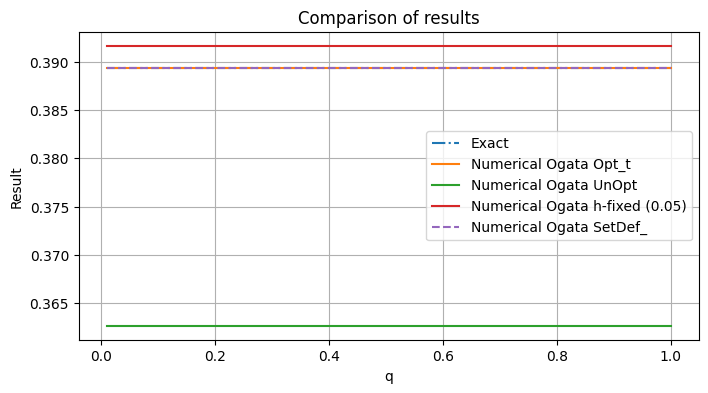

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess

# Range of q values
q_values = np.linspace(0.01, 1.0, 100)

# Output lists
exact_results = []
numerical_transformed_results_01 = []
numerical_transformed_results_02 = []
numerical_transformed_results_03 = []
numerical_transformed_results_04 = []

# Call your CUDA program with each q value and store the results
for q in q_values:
    output = subprocess.check_output(["./example", str(q)]).decode("utf-8").strip()

    output_lines = output.split("\n")  # split the output string into lines
    results = {}  # store the results in a dictionary
    for line in output_lines:
        label, number_string = line.split("=")  # split each line into a label and a number string
        number = float(number_string)  # convert the number string to a float
        results[label.strip()] = number  # store the number in the dictionary under the label

    # Save the results in the lists
    exact_results.append(results["Exact"])
    numerical_transformed_results_01.append(results["Numerical Ogata Opt_t"])
    numerical_transformed_results_02.append(results["Numerical Ogata UnOpt"])
    numerical_transformed_results_03.append(results["Numerical Ogata h-fixed (0.05)"])
    numerical_transformed_results_04.append(results["Numerical Ogata SetDef_"])

# Plot the results
plt.figure(figsize=(8,4))
plt.plot(q_values, exact_results, label="Exact", linestyle='dashdot')
plt.plot(q_values, numerical_transformed_results_01, label="Numerical Ogata Opt_t")
plt.plot(q_values, numerical_transformed_results_02, label="Numerical Ogata UnOpt")
plt.plot(q_values, numerical_transformed_results_03, label="Numerical Ogata h-fixed (0.05)")
plt.plot(q_values, numerical_transformed_results_04, label="Numerical Ogata SetDef_", linestyle='--')

plt.legend()
plt.xlabel('q')
plt.ylabel('Result')
plt.title('Comparison of results')
plt.grid(True)
plt.show()


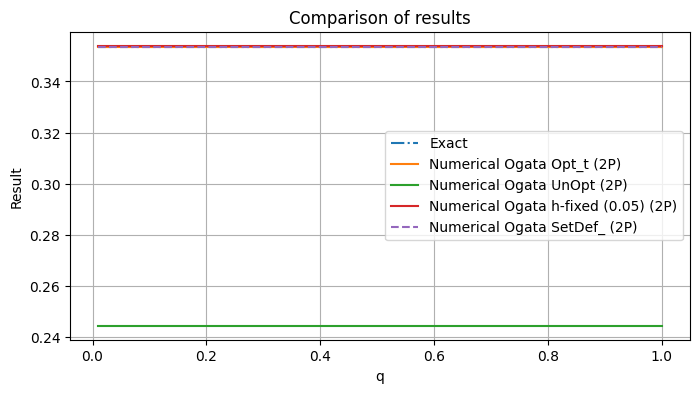

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess

# Range of q values
q_values = np.linspace(0.01, 1.0, 100)

# Output lists
exact_results = []
numerical_transformed_results_01 = []
numerical_transformed_results_02 = []
numerical_transformed_results_03 = []
numerical_transformed_results_04 = []

# Call your CUDA program with each q value and store the results
for q in q_values:
    output = subprocess.check_output(["./example2p", str(q)]).decode("utf-8").strip()

    output_lines = output.split("\n")  # split the output string into lines
    results = {}  # store the results in a dictionary
    for line in output_lines:
        label, number_string = line.split("=")  # split each line into a label and a number string
        number = float(number_string)  # convert the number string to a float
        results[label.strip()] = number  # store the number in the dictionary under the label

    # Save the results in the lists
    exact_results.append(results["Exact"])
    numerical_transformed_results_01.append(results["Numerical Ogata Opt_t 2p"])
    numerical_transformed_results_02.append(results["Numerical Ogata UnOpt 2p"])
    numerical_transformed_results_03.append(results["Numerical Ogata h-fixed(0.05) 2p"])
    numerical_transformed_results_04.append(results["Numerical Ogata SetDef_ 2p"])

# Plot the results
plt.figure(figsize=(8,4))
plt.plot(q_values, exact_results, label="Exact", linestyle='dashdot')
plt.plot(q_values, numerical_transformed_results_01, label="Numerical Ogata Opt_t (2P)")
plt.plot(q_values, numerical_transformed_results_02, label="Numerical Ogata UnOpt (2P)")
plt.plot(q_values, numerical_transformed_results_03, label="Numerical Ogata h-fixed (0.05) (2P)")
plt.plot(q_values, numerical_transformed_results_04, label="Numerical Ogata SetDef_ (2P)", linestyle='--')

plt.legend()
plt.xlabel('q')
plt.ylabel('Result')
plt.title('Comparison of results')
plt.grid(True)
plt.show()


In [24]:
%%writefile Makefile

NVCC = nvcc
NVCC_FLAGS =  -std=c++11 -arch=sm_50
G++ = g++

EXECUTABLE = fourier_bessel_transform
BOOST_EXECUTABLE = boost_math

SRC_DIR = src
INC_DIR = include

CUDA_SOURCES = $(SRC_DIR)/FBT.cu $(SRC_DIR)/example.cu
CPP_SOURCE = $(SRC_DIR)/BoostMath.cpp

all: $(EXECUTABLE) $(BOOST_EXECUTABLE)

$(EXECUTABLE): $(CUDA_SOURCES)
	$(NVCC) $(NVCC_FLAGS) -I$(INC_DIR) -o $@ $^

$(BOOST_EXECUTABLE): $(CPP_SOURCE)
	$(G++) -o $@ $^

clean:
	rm -f $(EXECUTABLE) $(BOOST_EXECUTABLE)


Writing Makefile


In [26]:
!make

nvcc -std=c++11 -arch=sm_50 -Iinclude -o fourier_bessel_transform src/FBT.cu src/example.cu
g++ -o boost_math src/BoostMath.cpp


In [28]:
!./boost_math

In [29]:
!./fourier_bessel_transform

Exact = 0.389400391535702439238519900755
Numerical Ogata Opt_t = 0.389400875936993740022984411553
Numerical Ogata UnOpt = 0.362642273751486443611469212556
Numerical Ogata h-fixed (0.05) = 0.391671898726995981743215224924
Numerical Ogata SetDef_ = 0.389412052802656394323577160321
